In [1]:
%matplotlib notebook
import chess
import numpy as np
import pickle
import hedgehog_functions_rl as hfr
import matplotlib.pyplot as plt

In [2]:
chess.__version__

'0.24.2'

## - Initialization of the model

In [3]:
np.random.seed(123)
model = hfr.Model(18,36,36,1)
model.adam_init(beta1 = 0.9, beta2 = 0.999, epsilon = 1.0e-8)
print("Number of paramters in the model is {:d}.".format(model.parameters_count))

Number of paramters in the model is 2053.


In [4]:
n = 20000 # number of games to be played
train_data = np.zeros((n,8)) # data that will be saved during training: mean abs error, mse, result of the game, number of moves

## - Training

In [5]:
np.random.seed(123)

for i in range(0,n):
    
    board = hfr.initial_position()
           
    board_end, values_array, dW1_array, db1_array, dW2_array, db2_array, dW3_array, db3_array  = hfr.game_for_update(
            board, model, hfr.features, insufficient_material_value = 30., stalemate_value = 4.)
    
    m = len(values_array)
    d = 1 + values_array[1:m] - values_array[0:m-1]
    train_data[i,0] = np.mean(np.abs(d))
    train_data[i,1] = np.mean(np.square(d))
    
    if board_end.result(claim_draw=True) == '1-0': train_data[i,2] = 1
    if board_end.is_stalemate(): train_data[i,3] = 1
    if board_end.is_insufficient_material(): train_data[i,4] = 1
    if board_end.can_claim_threefold_repetition(): train_data[i,5] = 1
    if board_end.can_claim_fifty_moves(): train_data[i,6] = 1
    train_data[i,7] = len(values_array) - 1
    
    if board_end.result(claim_draw=True) == "1-0" or board_end.is_insufficient_material():
        
        dW1, db1, dW2, db2, dW3, db3 = hfr.update_sums(values_array, 
                                dW1_array, db1_array, dW2_array, db2_array, dW3_array, db3_array, lam = 0.25)
        
        model.adam_update(dW1, db1, dW2, db2, dW3, db3)
    
        model.update_parameters(learning_rate = 0.001)  
    
    if (i+1) % 1000 == 0:
        print("Trained on {:d} games, with {:.0f} white wins in last 1000 games.".format(i+1,np.sum(train_data[i-999:i+1,2])))

Trained on 1000 games, with 21 white wins in last 1000 games.
Trained on 2000 games, with 14 white wins in last 1000 games.
Trained on 3000 games, with 22 white wins in last 1000 games.
Trained on 4000 games, with 19 white wins in last 1000 games.
Trained on 5000 games, with 24 white wins in last 1000 games.
Trained on 6000 games, with 26 white wins in last 1000 games.
Trained on 7000 games, with 48 white wins in last 1000 games.
Trained on 8000 games, with 109 white wins in last 1000 games.
Trained on 9000 games, with 454 white wins in last 1000 games.
Trained on 10000 games, with 641 white wins in last 1000 games.
Trained on 11000 games, with 717 white wins in last 1000 games.
Trained on 12000 games, with 763 white wins in last 1000 games.
Trained on 13000 games, with 784 white wins in last 1000 games.
Trained on 14000 games, with 881 white wins in last 1000 games.
Trained on 15000 games, with 940 white wins in last 1000 games.
Trained on 16000 games, with 932 white wins in last 1000

## - Save model and data

In [6]:
with open('model.obj', 'wb') as file:
    pickle.dump(model, file)

In [7]:
np.save('train_data.npy', train_data)

## - Results

In [8]:
def running_mean(x,N):
    cumsum = np.cumsum(x)
    cumsum[N:] = cumsum[N:] - cumsum[:-N]
    return (cumsum[N-1:]) / float(N)

<IPython.core.display.Javascript object>


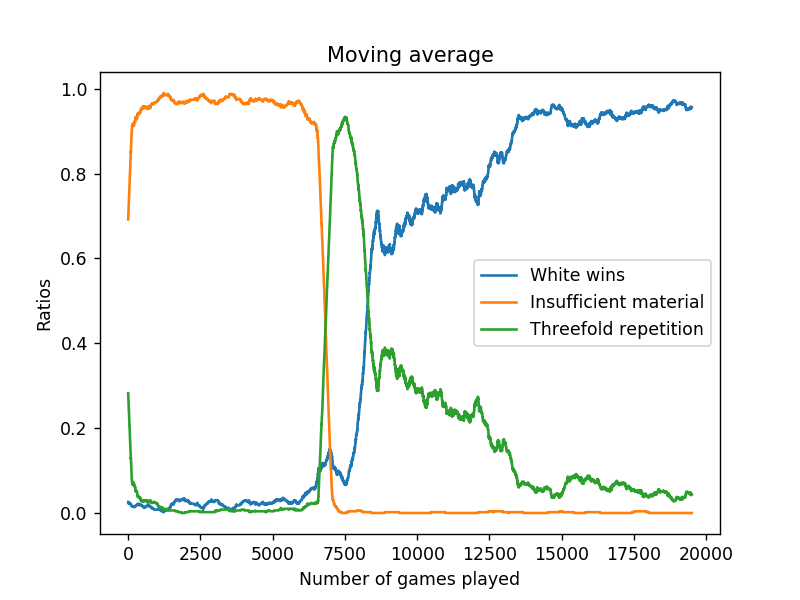

In [9]:
n = 500
plt.figure()
plt.plot(running_mean(train_data[:,2],n), label = "White wins")
#plt.plot(running_mean(train_data[:,3],n), label = "Stalemate")
plt.plot(running_mean(train_data[:,4],n), label = "Insufficient material")
plt.plot(running_mean(train_data[:,5],n), label = "Threefold repetition")
#plt.plot(running_mean(train_data[:,6],n), label = "Fifty_moves")
plt.xlabel('Number of games played')
plt.ylabel('Ratios')
plt.title('Moving average')
plt.legend()

## - Errors

The error in the predicted number of moves to mate decreases as training progresses.

<IPython.core.display.Javascript object>


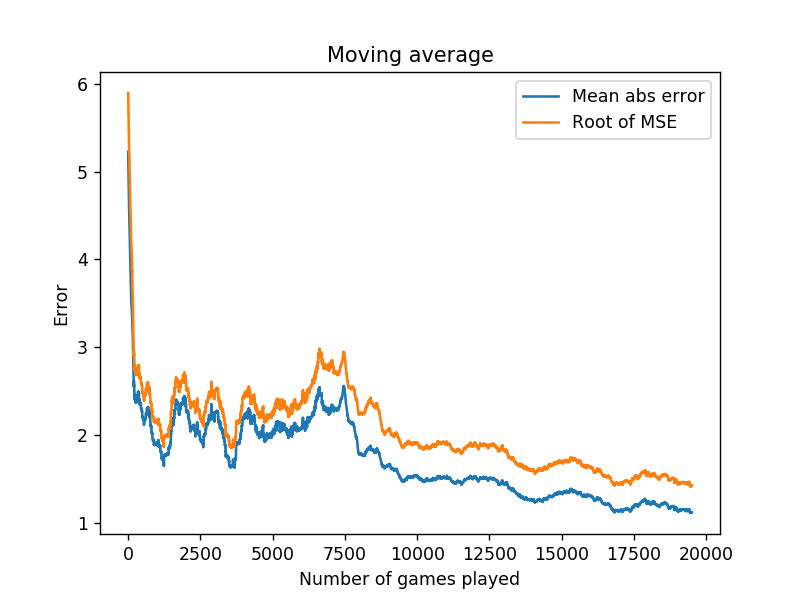

In [14]:
n = 500
plt.figure()
plt.plot(running_mean(train_data[:,0],n), label = "Mean abs error")
plt.plot(running_mean(np.sqrt(train_data[:,1]),n), label = "Root of MSE")
plt.xlabel('Number of games played')
plt.ylabel('Error')
plt.title('Moving average')
plt.legend()

## - Number of moves played per game

In the later stages of training most of the games end with a white win. Number of moves played in the later stages of training decrease which means that checkmate is delivered quicker.

<IPython.core.display.Javascript object>


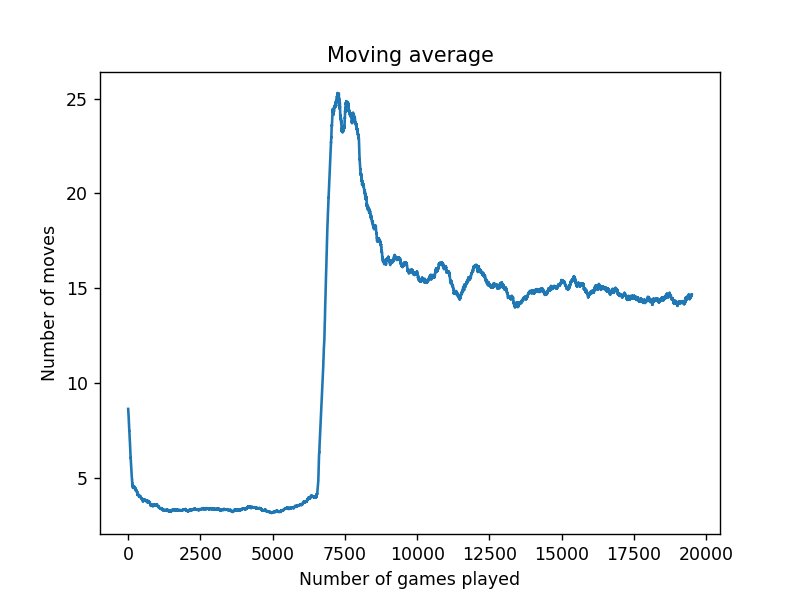

Text(0.5, 1.0, 'Moving average')

In [18]:
n = 500
plt.figure()
plt.plot(running_mean(train_data[:,7],n))
plt.xlabel('Number of games played')
plt.ylabel('Number of moves')
plt.title('Moving average')